# Exploring the data, basic fitting and visualization

#### Handle the imports

In [1]:
#First import the standard toolboxes
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd

#Import the specific functions for this class
import encoding_tools

#Import some sklearn functions


#### Download the data from the gdrive and load it

In [2]:
data_file = encoding_tools.download_neural_data("miniscope") #Download function from io
data_dict = np.load(data_file, allow_pickle = True).tolist()

#Create a variable for each keyword in the dictionary
for key,val in data_dict.items():
        exec(key + '=val')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1cLbUqh2LKLXuwqXdjyvMi4DuKMFC0DiM
From (redirected): https://drive.google.com/uc?id=1cLbUqh2LKLXuwqXdjyvMi4DuKMFC0DiM&confirm=t&uuid=a4c6c11f-a6ba-48ec-958a-275ef7e02212
To: C:\Users\Lukas Oesch\Documents\ChurchlandLab\DataSAI_data_folder\miniscope_data.npy
100%|██████████████████████████████████████████████████████████████████████████████| 1.30G/1.30G [00:12<00:00, 102MB/s]


#### What are these data?

The data we have loaded were obtained from a mouse performing a 2AFC task discriminating between high-frequency (> 12 Hz) and low-frequency (< 12 Hz) click trains. We recorded excitatory neurons in the anterior cingulate cortex of this mouse during the task performance while video tracking the animal's movements. What do the indiviudal variables mean?

<ul>
    <li> <strong>desing_matrix</strong>: This is the heart of the encoding model we are going to build. It contains a set of task and movement variables aligned to four distinct phases of the task, size is number of total frames x regressor number.</li>
 <li><strong>Y_raw_fluorescence</strong>: The fluorescence traces from all the neurons recorded algined to the same task phases as the task- and movement variables, size is number of total frames x neuron number</li>
 <li><strong>neuron_footprints</strong>: The spatial filters for the recorded neurons, size is 300 pixels x 300 pixels x neuron number. </li>
 <li><strong>timepoints_per_trial</strong>: The number of frames per trial.</li>
  <li><strong>aligned_segment_start</strong>: Marks the frames where the activity was aligned to a new task event. This means that these frames are discontinuous to the previous ones.</li>
 </ul>


## Exercise 1: What is the structure of the desing matrix?

Lets start by looking at the task variables inside the design matrix:

<ul>
    <li>time (the intercept per trial timepoint)</li>
    <li>choice</li>
    <li>stimulus strength</li>
    <li>outcome</li>
    <li>previous choice</li>
    <li>previous outcome</li>
</ul> 

Let's  print some of the keys of the data frame and plot the task variable columns!

Index(['time_t0', 'choice_t0', 'stim_strength_t0', 'outcome_t0',
       'previous_choice_t0', 'previous_outcome_t0'],
      dtype='object')


<IPython.core.display.Javascript object>


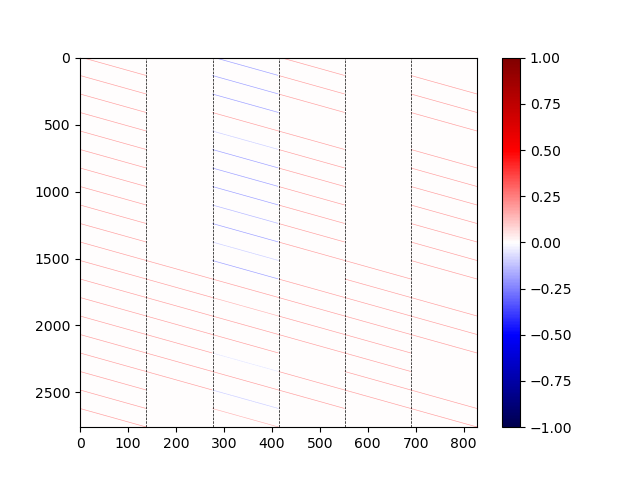

In [5]:
#Print some of the keys of the design matrix
print(design_matrix.keys()[np.arange(0,6 * timepoints_per_trial, timepoints_per_trial)])

#Plot the task variables
plt.figure()
plt.imshow(np.array(design_matrix)[:20 * timepoints_per_trial,:6 * timepoints_per_trial], aspect = 'auto', cmap = 'seismic')
#use np.array() on the design_matrix to be able to index numerically instead of by key
for k in range(6):
    plt.axvline(k * timepoints_per_trial, color='k', linestyle='--', linewidth=0.5)
plt.colorbar()

######---Try answering the following questions:
# Does the t0 on the keys mean?
# Why is the first column bounded by dashed lines all diagonals?
# Why are the other ones not all diagonals?
# What do negative values along the diagonal indicate?

<IPython.core.display.Javascript object>


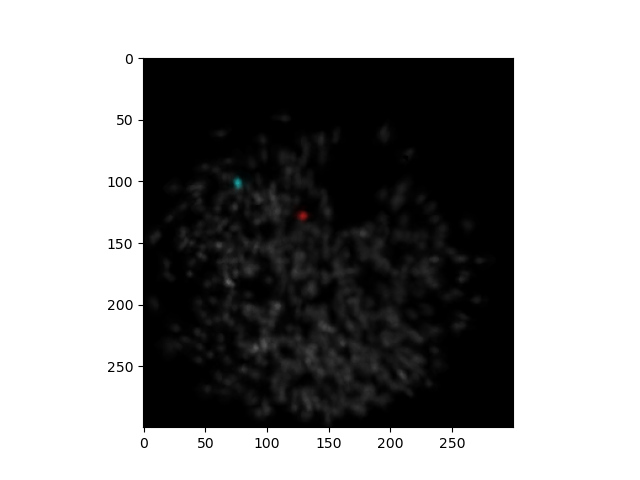

In [6]:
#Plot two example neurons: neuron 56 in red and neuron 12 in cyan superimposed on top of all the other identified cells
encoding_tools.overlay_neurons(neuron_footprints, 56, 12, 12) #Pass the neuron ids for the red, green and blue channel

In [10]:
## Exercise 2: Plot a peri-stimulus time histogram



828